In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

In [2]:
path = '/Users/luca/Python#/Tcell-ZYdataset/mergedata_20211001.loom' 

In [3]:
adata = sc.read_loom(path, var_names = 'var_names', obs_names = 'obs_names')

In [4]:
temp = adata[(adata.obs.cell_quality == 'high') & #filtering high quality cells from kids ONLY
                 (adata.obs.platform == '10X') & 
                 (adata.obs.doublets != 'doublets'),].copy()

In [5]:
DCs= temp[((temp.obs.cell_subtype_new=='conventional DCs')|
            (temp.obs.cell_subtype_new == 'plasmacytoid DCs')),].copy()

In [6]:
DCs

AnnData object with n_obs × n_vars = 1371 × 37907
    obs: 'Age', 'Condition', 'DENV_minus', 'DENV_plus', 'DENV_reads', 'Gender', 'ID', 'batch', 'cell_quality', 'cell_subtype', 'cell_subtype_2', 'cell_subtype_new', 'cell_type', 'cell_type_new', 'cell_type_new_2', 'doublets', 'mt_frac', 'n_counts', 'n_genes', 'platform', 'viral_load_nano', 'viral_load_qpcr'
    var: 'feature_types_10X', 'feature_types_plate'

In [7]:
def cluster (DCs):
    sc.pp.highly_variable_genes(DCs, flavor='cell_ranger', n_top_genes=2000)
    sc.pp.pca(DCs, n_comps=40, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(DCs, n_pcs = 15)
    sc.tl.umap(DCs)
    sc.tl.leiden(DCs, resolution=1, key_added = 'leiden_r1')
    sc.tl.leiden(DCs, resolution=0.5, key_added = 'leiden_r0.5')
    sc.tl.rank_genes_groups(DCs, groupby='leiden_r1', key_added='rank_genes_r1')
    sc.tl.rank_genes_groups(DCs, groupby='leiden_r0.5', key_added='rank_genes_r0.5')
    
def removegenes(DCs):
    """remove human HLA genes from the dataset 
    Parameters:
    ----------
    adata: scanpy.adata
        scanpy adata object

    Returns:
    -------
    temp: scanpy.adata
        scanpy adata object
    """

    IGKV = [x for x in DCs.var_names if x.startswith('IGKV')]
    IGHV = [x for x in DCs.var_names if x.startswith('IGHV')]
    IGLV = [x for x in DCs.var_names if x.startswith('IGLV')]
    IGLC = [x for x in DCs.var_names if x.startswith('IGLC')]
    IGLL = [x for x in DCs.var_names if x.startswith('IGLL')]
    IGKC = [x for x in DCs.var_names if x.startswith('IGKC')]
    IGHC = [x for x in DCs.var_names if x.startswith('IGHC')]
    TRAV = [x for x in DCs.var_names if x.startswith('TRAV')]
    TRBV = [x for x in DCs.var_names if x.startswith('TRBV')]
    
    #try removing IGHG genes and MZB1 and JCHAIN
#     IGHG = [x for x in adata.var_names if x.startswith('IGHG')]
    exclude = IGKV + IGHV + IGLV + IGLC + IGLL + IGKC + IGHC + TRAV + TRBV 
    gene = [x for x in DCs.var_names if x not in exclude]
    temp = DCs[:,gene].copy()
    return(temp)

In [8]:
#normalize data
sc.pp.normalize_total(DCs, target_sum=1e6)
sc.pp.log1p(DCs, base=2)

In [9]:
# remove human HLA genes from the dataset
DCs = removegenes(DCs)
DCs = DCs[(DCs.obs.cell_subtype_new != 'doublets') & 
                        (DCs.obs.cell_subtype_new != 'unknown')].copy()

In [11]:
sc.pp.filter_genes(DCs, min_cells=3)

In [12]:
# UMAP
sc.pp.highly_variable_genes(DCs, flavor='cell_ranger', n_top_genes=2000)
sc.pp.pca(DCs, n_comps=40, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(DCs, n_pcs = 15)
sc.tl.umap(DCs)

... storing 'Condition' as categorical
... storing 'DENV_minus' as categorical
... storing 'DENV_plus' as categorical
... storing 'Gender' as categorical
... storing 'ID' as categorical
... storing 'batch' as categorical
... storing 'cell_quality' as categorical
... storing 'cell_subtype' as categorical
... storing 'cell_subtype_2' as categorical
... storing 'cell_subtype_new' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_new' as categorical
... storing 'cell_type_new_2' as categorical
... storing 'doublets' as categorical
... storing 'platform' as categorical
... storing 'feature_types_10X' as categorical
... storing 'feature_types_plate' as categorical


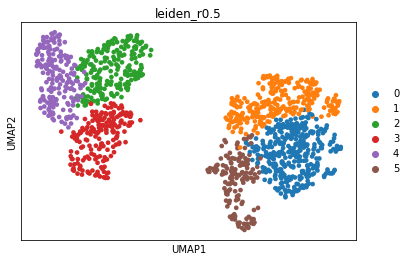

In [13]:
sc.tl.leiden(DCs, resolution=0.5, key_added = 'leiden_r0.5')
sc.pl.umap(DCs, color=['leiden_r0.5'])

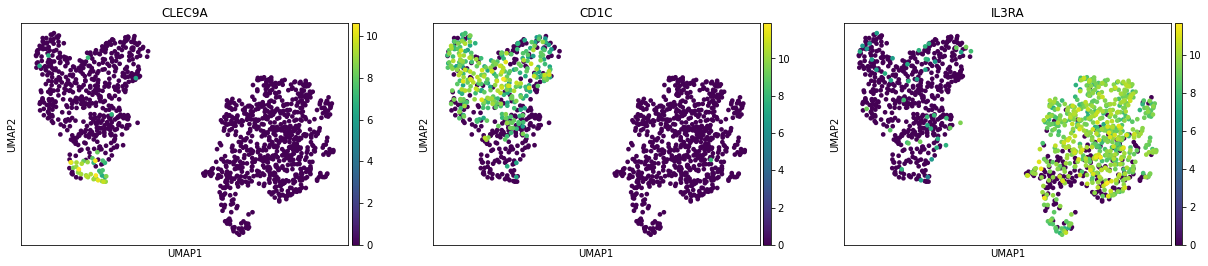

In [14]:
sc.pl.umap(DCs, color=['CLEC9A','CD1C','IL3RA'])

In [15]:
sc.tl.rank_genes_groups(DCs, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

In [16]:
marker_genes = ['CLEC9A','CD1C','IL3RA']

In [17]:
np.in1d(marker_genes, DCs.var_names)

array([ True,  True,  True])

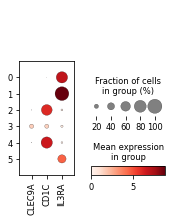

In [18]:
ax = sc.pl.dotplot(DCs, marker_genes, groupby='leiden_r0.5', use_raw=False)

In [20]:
DCs.obs['Dc_annotated1'] = DCs.obs['leiden_r0.5'].cat.add_categories(['Dc1','Dc2','pDc'])

In [21]:
DCs.obs['Dc_annotated1'][np.in1d(DCs.obs['Dc_annotated1'], ['3'])] = 'Dc1'
DCs.obs['Dc_annotated1'][np.in1d(DCs.obs['Dc_annotated1'], ['2','4'])] = 'Dc2'
DCs.obs['Dc_annotated1'][np.in1d(DCs.obs['Dc_annotated1'], ['0','1','5'])] = 'pDc'

DCs.obs['Dc_annotated1'] = DCs.obs['Dc_annotated1'].cat.remove_unused_categories()

In [22]:
DCs.obs['Dc_annotated1'].value_counts()

pDc    778
Dc2    401
Dc1    192
Name: Dc_annotated1, dtype: int64